In [1]:
import pandas as pd
import numpy as np

from scipy.stats import multinomial

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

%matplotlib inline

In [2]:
df = pd.read_csv('wdbc.data', header=None)
df = df.drop(0, axis=1)

In [3]:
df[1] = df[1] == 'B'
df[1] = df[1].astype(int)

In [4]:
df[1].value_counts()

1    357
0    212
Name: 1, dtype: int64

In [5]:
data_x, test_x, data_y, test_y = train_test_split(df.drop(1, axis=1), df[1], random_state=42,
                                                  test_size=.3)

In [6]:
data_x = data_x.reset_index(drop=True)
data_y = data_y.reset_index(drop=True)

In [7]:
known_labels = data_y[data_y == 0].sample(frac=0.15, random_state=42).index

## CLF Test 1

In [8]:
def fit_new_labels(_data, _known_idx, _clf):
    _known_data = _data.loc[_known_idx]
    _known_labels = pd.Series(np.zeros(_known_data.shape[0]), index=_known_idx)
    
    _unknown_labels = pd.Series(np.ones(_data.shape[0]), index=_data.index)
    
    _train_data = pd.concat([_known_data, _data], axis=0)
    _train_targets = pd.concat([_known_labels, _unknown_labels], axis=0)
    _clf.fit(_train_data, _train_targets)
    
    return _train_data, _train_targets, _clf

def score_new_labels(_data, _known_idx, _clf, min_cutoff=False):
    _preds = pd.DataFrame(_clf.predict_proba(_data), _data.index)
    if not min_cutoff:
        min_cutoff = _preds.iloc[:_known_idx.shape[0],0].min()
    _preds['pred'] = _preds[0] < min_cutoff
    _preds['pred'] = _preds['pred'].astype(int)
    print(min_cutoff)
    
    return _preds, min_cutoff

def extract_new_labels(_preds):
    _new_labels = _preds[_preds['pred'] == 0].index
    return _new_labels

In [9]:
def run_scoring_session(data, labels, min_cutoff=False, estimators=10):
    clf = RandomForestClassifier(n_estimators=estimators, random_state=42, n_jobs=-1)
    _data, _targets, _clf = fit_new_labels(data, labels, clf)
    preds, min_cutoff = score_new_labels(_data, labels, _clf, min_cutoff)
    new_labels = extract_new_labels(preds)
    
    return preds, new_labels, min_cutoff, clf

In [10]:
def loop_till_done(_data, _known_labels, _n_estimators, runs=5):
    _preds, _labels, min_cutoff = run_scoring_session(_data, _known_labels, 
                                                                estimators=_n_estimators)
    for i in range(runs):
        print(i)
        print(min_cutoff)
        if min_cutoff > 0:
            _preds, _labels, min_cutoff, clf = run_scoring_session(_data, _labels.drop_duplicates(), min_cutoff)
        else:
            return _preds, _labels, min_cutoff
    return _preds, _labels, min_cutoff, clf

In [33]:
estimators = 35

In [34]:
continuity_labels = known_labels.drop_duplicates()

In [35]:
preds, new_labels, min_cutoff, clf = run_scoring_session(data_x, known_labels.drop_duplicates(), 
                                                         estimators=estimators)

0.3238095238095238


In [36]:
scores = list()
score_dfs = list()
clfs = list()
labeling = list()

In [37]:
scoring = preds.reset_index()
scoring = scoring.drop_duplicates(subset='index')
scoring = scoring.set_index('index')
scoring = scoring.sort_index()
scoring['org'] = data_y
score_dfs.append(scoring)

continuity_labels = pd.Index(set(continuity_labels.drop_duplicates().values).union(set(new_labels.values)))

clfs.append(clf)
labeling.append(continuity_labels)

In [38]:
preds_2, labels_, min_cutoff, clf = run_scoring_session(data_x, continuity_labels.drop_duplicates(), min_cutoff,
                                                        estimators=10)

labels_ = pd.Index(set(continuity_labels.drop_duplicates().values).union(set(labels_.values)))


scoring = preds_2.reset_index()
scoring = scoring.drop_duplicates(subset='index')
scoring = scoring.set_index('index')
scoring = scoring.sort_index()
scoring['org'] = data_y
score_dfs.append(scoring)

fpr, tpr, _ = roc_curve(scoring['org'], scoring[0], pos_label=0)
roc_auc = auc(fpr, tpr)

scores.append((auc(fpr, tpr), min_cutoff))
clfs.append(clf)
labeling.append(continuity_labels)

0.3238095238095238


In [39]:
previous_min_cutoff = 0
for i in range(20):
    print(i)
#     preds_, labels_, min_cutoff = run_scoring_session(data_x, labels_.drop_duplicates(),min_cutoff)
    preds_, labels_, min_cutoff, clf = run_scoring_session(data_x, continuity_labels.drop_duplicates(),
                                                            estimators=10)
    
    continuity_labels = pd.Index(set(continuity_labels.drop_duplicates().values).union(set(labels_.values)))


    scoring = preds_.reset_index()
    scoring = scoring.drop_duplicates(subset='index')
    scoring = scoring.set_index('index')
    scoring = scoring.sort_index()
    scoring['org'] = data_y
    score_dfs.append(scoring)

    fpr, tpr, _ = roc_curve(scoring['org'], scoring[0], pos_label=0)
    roc_auc = auc(fpr, tpr)

    scores.append((auc(fpr, tpr), min_cutoff))
    clfs.append(clf)
    labeling.append(continuity_labels)

0
0.2333333333333333
1
0.24833333333333335
2
0.225
3
0.29166666666666663
4
0.27666666666666667
5
0.27666666666666667
6
0.27666666666666667
7
0.2766666666666667
8
0.27666666666666667
9
0.27666666666666667
10
0.27666666666666667
11
0.27666666666666667
12
0.27666666666666667
13
0.27666666666666667
14
0.27666666666666667
15
0.27666666666666667
16
0.27666666666666667
17
0.27666666666666667
18
0.27666666666666667
19
0.27666666666666667


In [40]:
plotting = pd.DataFrame(scores)

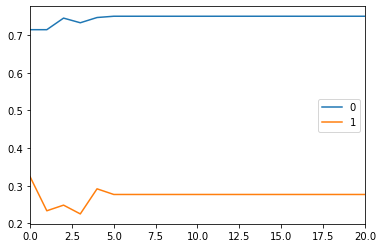

In [41]:
plotting[[0,1]].plot()

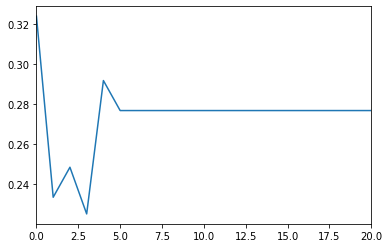

In [42]:
plotting[1].plot()

In [43]:
len(score_dfs)

22

In [44]:
plotting[1] = plotting[1].round(4)

In [47]:
plateau_score = plotting.iloc[-1,1]
top_scores = plotting[plotting[1] > plateau_score].iloc[1:]

if top_scores.empty:
    best_run = 0
else:
    best_run = top_scores[1].idxmax()
best_run

4

In [48]:
top_scores.head()

,0,1
4,0.74688,0.2917


In [49]:
print(classification_report(score_dfs[best_run]['org'], score_dfs[best_run]['pred']))

              precision    recall  f1-score   support

           0       0.96      0.18      0.31       149
           1       0.67      1.00      0.80       249

    accuracy                           0.69       398
   macro avg       0.82      0.59      0.55       398
weighted avg       0.78      0.69      0.62       398



In [50]:
fpr, tpr, _ = roc_curve(score_dfs[best_run]['org'], score_dfs[best_run][0], pos_label=0)
roc_auc = auc(fpr, tpr)

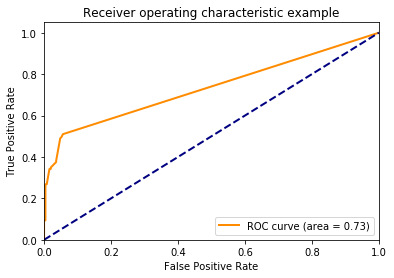

In [51]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [52]:
len(continuity_labels)

29

# Predict on holdout data

In [53]:
best_labels = pd.Series(np.ones(data_x.shape[0]))
best_labels.loc[labeling[best_run]] = 0

In [54]:
best_labels.value_counts()

1.0    370
0.0     28
dtype: int64

In [55]:
best_clf = RandomForestClassifier(n_estimators=150, random_state=42)
best_clf.fit(data_x, best_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [56]:
holdout_probs = pd.DataFrame(best_clf.predict_proba(test_x))

In [57]:
scores[best_run]

(0.746880138001671, 0.29166666666666663)

In [58]:
holdout_probs['pred'] = holdout_probs[0] < scores[best_run][1]
holdout_probs['pred'] = holdout_probs['pred'].astype(int)

In [59]:
holdout_preds = best_clf.predict(test_x)

holdout_preds = holdout_probs['pred']

In [60]:
print(classification_report(holdout_preds, test_y))

              precision    recall  f1-score   support

           0       0.21      1.00      0.34        13
           1       1.00      0.68      0.81       158

    accuracy                           0.71       171
   macro avg       0.60      0.84      0.58       171
weighted avg       0.94      0.71      0.78       171



In [61]:
fpr, tpr, _ = roc_curve(holdout_preds, test_y, pos_label=1)
roc_auc = auc(fpr, tpr)

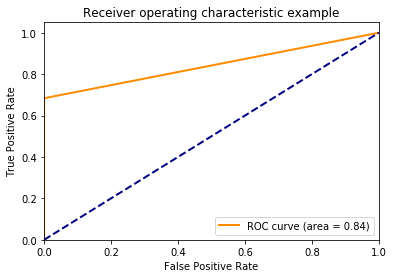

In [62]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [63]:
benchmark_labels = pd.Series(np.ones(data_x.shape[0]))
benchmark_labels.loc[known_labels] = 0

In [78]:
benchmark_clf = RandomForestClassifier(n_estimators=150, random_state=42)
# benchmark_clf.fit(data_x, benchmark_labels)
benchmark_clf.fit(data_x, data_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [79]:
benchmark_holdout_probs = pd.DataFrame(benchmark_clf.predict_proba(test_x))

In [80]:
benchmark_holdout_preds = benchmark_clf.predict(test_x)

In [81]:
print("LABED: {} :: VERSUS :: BENCHMARK {}".format(f1_score(holdout_preds, test_y).round(4),
                                                     f1_score(benchmark_holdout_preds, test_y).round(4)))

LABED: 0.812 :: VERSUS :: BENCHMARK 0.9772


In [82]:
print(classification_report(holdout_preds, test_y))

              precision    recall  f1-score   support

           0       0.21      1.00      0.34        13
           1       1.00      0.68      0.81       158

    accuracy                           0.71       171
   macro avg       0.60      0.84      0.58       171
weighted avg       0.94      0.71      0.78       171



In [83]:
print(classification_report(benchmark_holdout_preds, test_y))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        60
           1       0.99      0.96      0.98       111

    accuracy                           0.97       171
   macro avg       0.96      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [84]:
fpr, tpr, _ = roc_curve(benchmark_holdout_preds, test_y, pos_label=1)
roc_auc = auc(fpr, tpr)

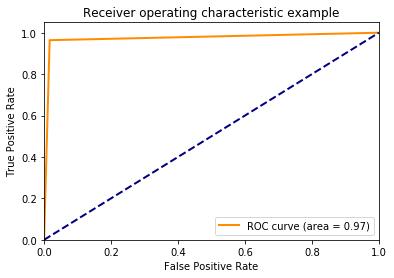

In [85]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()